# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [7]:
import numpy as np 
import pandas as pd 
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
%matplotlib inline

a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

                     pm2.5  Dew  Temperature  Pressure Wind_Direction  \
year_month_day_hour                                                     
2010-01-02 00:00:00  129.0  -16         -4.0    1020.0             SE   
2010-01-02 01:00:00  148.0  -15         -4.0    1020.0             SE   
2010-01-02 02:00:00  159.0  -11         -5.0    1021.0             SE   
2010-01-02 03:00:00  181.0   -7         -5.0    1022.0             SE   
2010-01-02 04:00:00  138.0   -7         -5.0    1022.0             SE   
2010-01-02 05:00:00  109.0   -7         -6.0    1022.0             SE   
2010-01-02 06:00:00  105.0   -7         -6.0    1023.0             SE   
2010-01-02 07:00:00  124.0   -7         -5.0    1024.0             SE   
2010-01-02 08:00:00  120.0   -8         -6.0    1024.0             SE   
2010-01-02 09:00:00  132.0   -7         -5.0    1025.0             SE   
2010-01-02 10:00:00  140.0   -7         -5.0    1026.0             SE   
2010-01-02 11:00:00  152.0   -8         -5.0    102

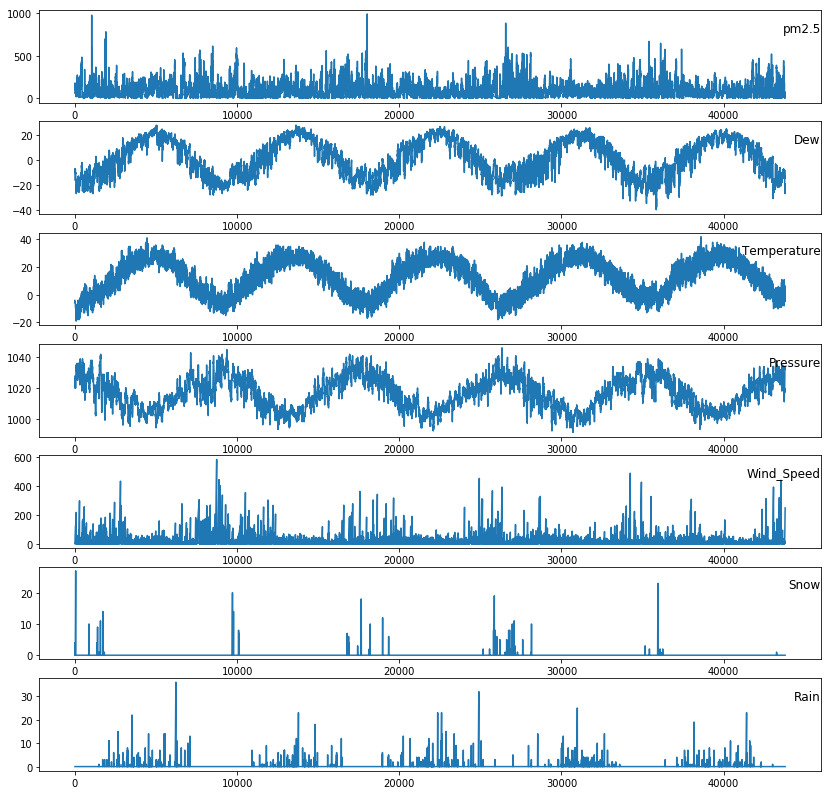

In [8]:
# write your code here
#Parse the data in a datafram and combine the date/time columns into a single column
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
pol_data = pd.read_csv("pollution.csv", parse_dates=[["year", "month", "day", "hour"]], date_parser=parse, header=0, index_col=0)
#Remove useless column
pol_data.drop(columns=["No"], inplace=True)
#Delete first 24 rows as pollution values are all NaN
pol_data = pol_data[24:]
#Replace missing pollution values with 0
pol_data["pm2.5"] = pol_data["pm2.5"].fillna(0)

print (pol_data)

#Plot values of appropriate columns over 5 year period 
cols = ["pm2.5", "Dew", "Temperature", "Pressure", "Wind_Speed", "Snow", "Rain"]
n = 1
plt.figure(figsize=[14,14])
for col in cols:
    plt.subplot(len(cols), 1, n)
    plt.plot(pol_data[col].values)
    plt.title(col, y=0.7, loc="right")
    n += 1

plt.show()

b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [55]:
from sklearn import preprocessing
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = pol_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# write your code here

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

Train on 7884 samples, validate on 876 samples
Epoch 1/50
7884/7884 [==============================] - 2s 249us/step - loss: 0.0076 - val_loss: 0.0093
Epoch 2/50
7884/7884 [==============================] - 0s 17us/step - loss: 0.0056 - val_loss: 0.0069
Epoch 3/50
7884/7884 [==============================] - 0s 17us/step - loss: 0.0043 - val_loss: 0.0049
Epoch 4/50
7884/7884 [==============================] - 0s 18us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/50
7884/7884 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/50
7884/7884 [==============================] - 0s 19us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/50
7884/7884 [==============================] - 0s 20us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/50
7884/7884 [==============================] - 0s 19us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/50
7884/7884 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/50
7884/7884 [==

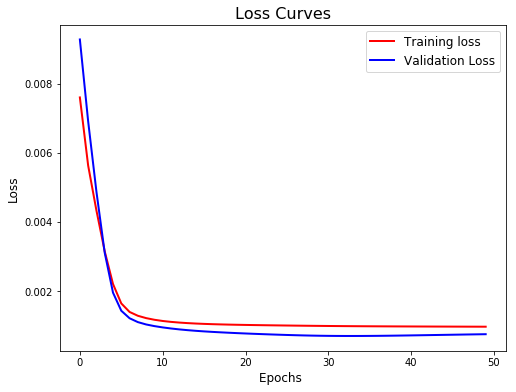

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout

# design network
model = Sequential()
model.add(LSTM(20, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
hist = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=.1, verbose=1, shuffle=False)

#Plot loss on training set vs loss on validation set
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=2.0)
plt.plot(hist.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=16)
plt.show()

# write your code here
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

"""
We can see that the two loss curves are very close together, indicating there isnt much over/under fitting.
"""

d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

(8760, 1, 8) (8760,) (35039, 8) (35039, 1)
Test RMSE: 45.660


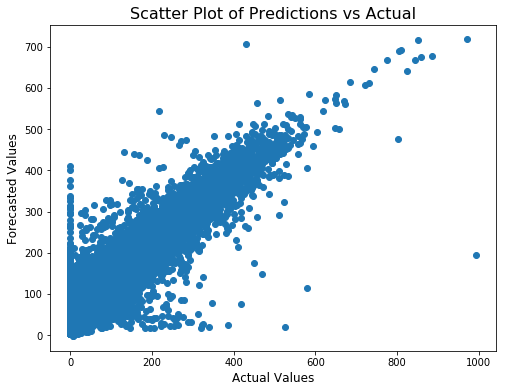

In [61]:
from sklearn.metrics import mean_squared_error
from numpy import concatenate

# make a prediction
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_test = x_test.reshape(x_test.shape[0], 1, 8)
yhat = model.predict(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, x_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, x_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# write your code here



plt.figure(figsize=[8,6])
plt.scatter(inv_y, inv_yhat)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel('Forecasted Values', fontsize=12)
plt.title("Scatter Plot of Predictions vs Actual", fontsize=16)
plt.show()

"""
Looking at the scatter plot, we can see that the predictions for the actual values is not the best between 0-300,
but it does improve for actual values > 400.
This suggests that a more complex model is needed.
"""

e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

In [54]:
# write your code here

f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

In [14]:
# write your code here